# Software development patterns through git data mining

In [29]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`.

In [41]:
vis = Visualizer(project_name='petsc')
vis.get_data()

INFO: Loaded local cached copy of petsc data.
INFO: Cleaning up data and computing averages...
INFO: Done computing averages. 186696 commits (code only)


In [3]:
vis.commit_data.shape

(186696, 18)

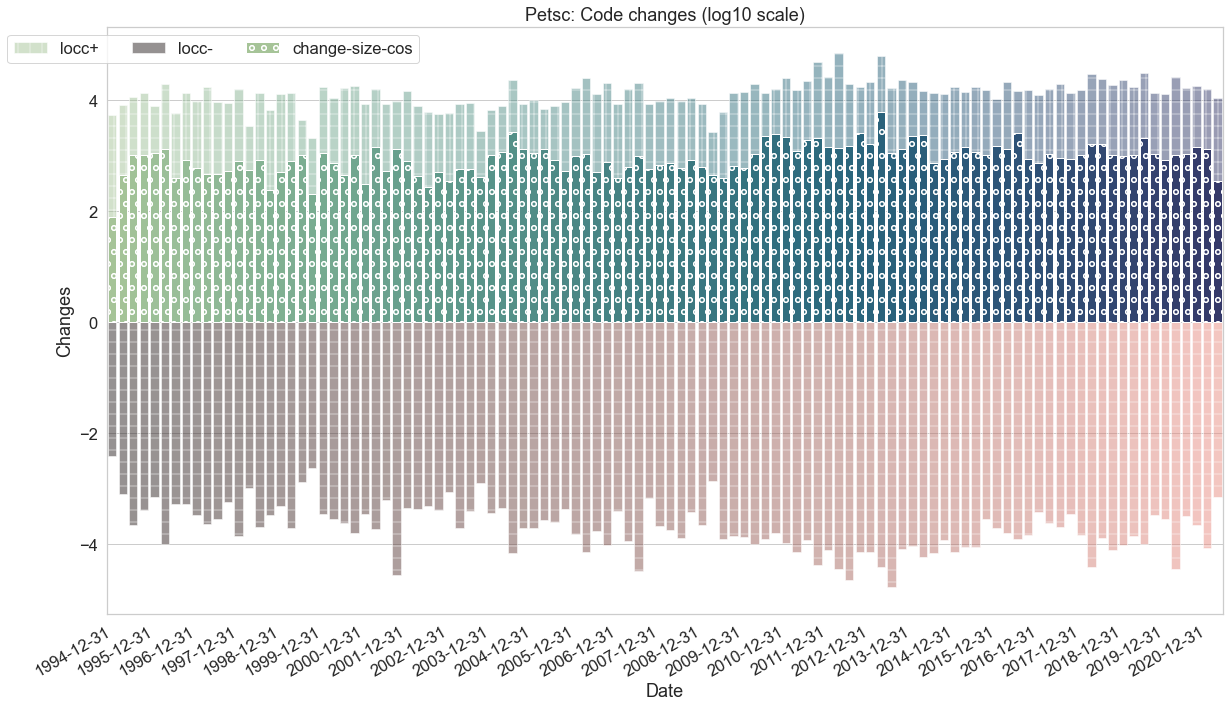

In [4]:
df = vis.plot_overall_project_locc(time_range=None, log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [5]:
vis.set_year(2020)
vis.set_month(7)

to plot for a given year, provide *time_range='year'*

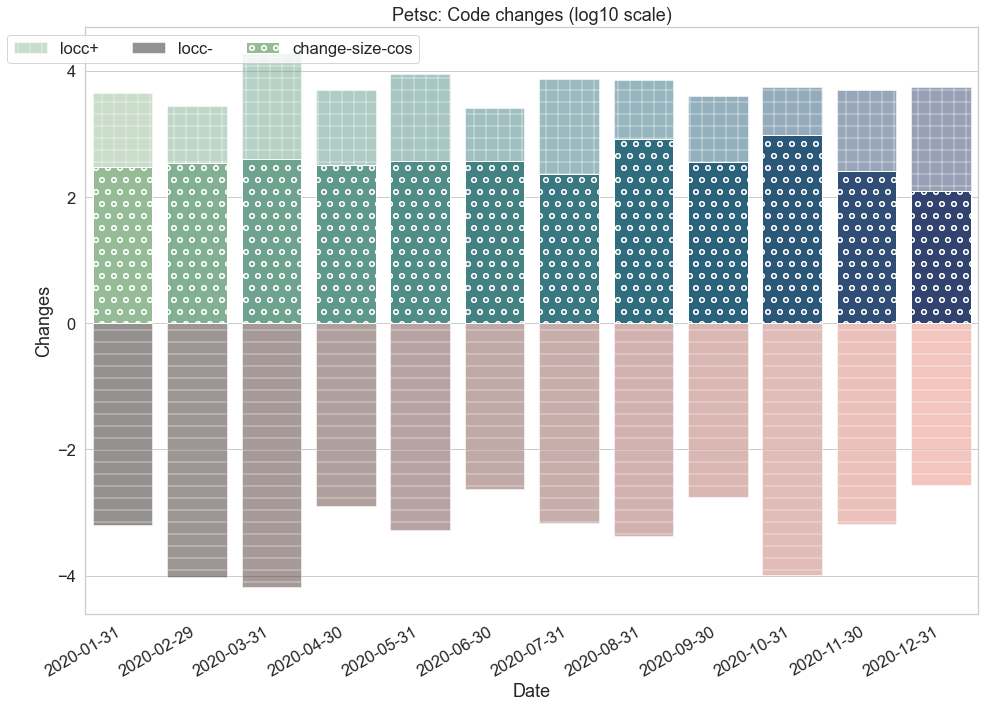

In [6]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

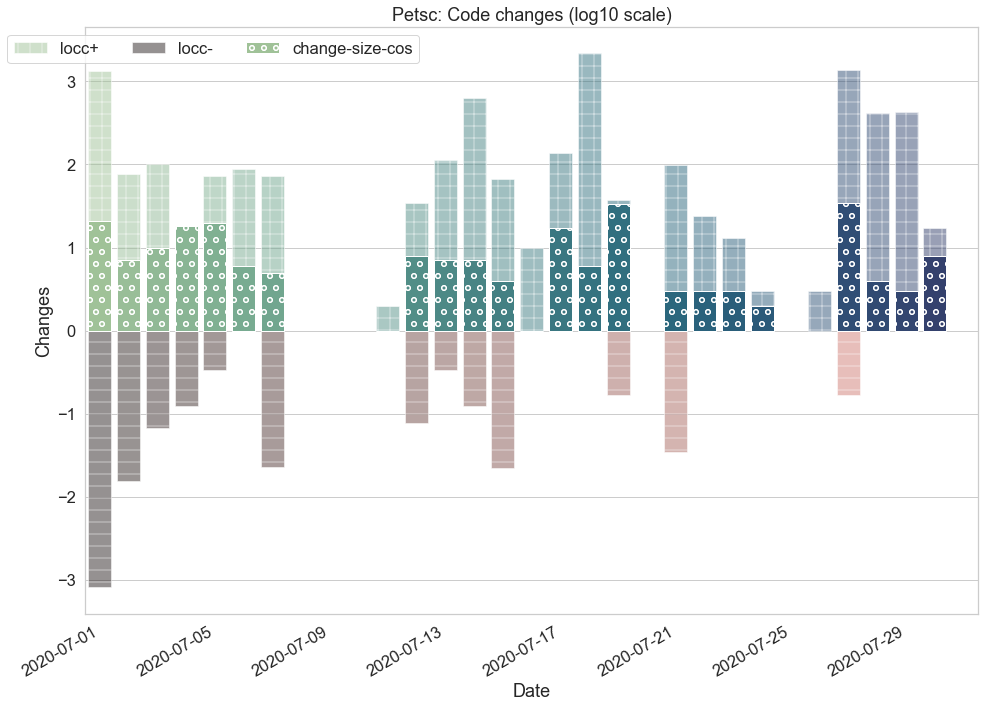

In [7]:
df = vis.plot_overall_project_locc(time_range='month',log=True)

### Averages: Total changed lines over time

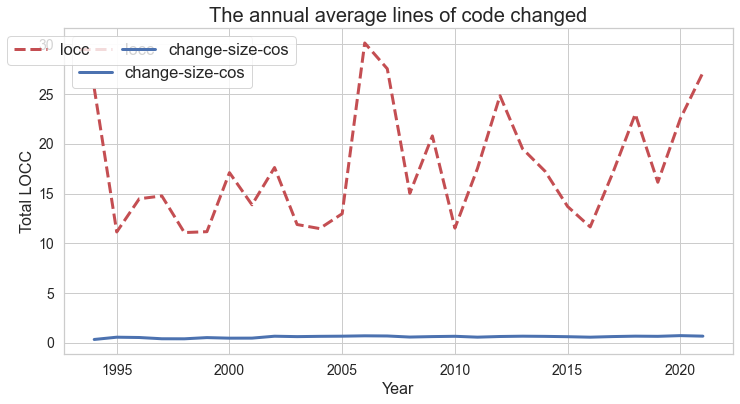

In [8]:
vis.plot_total_locc_avg()

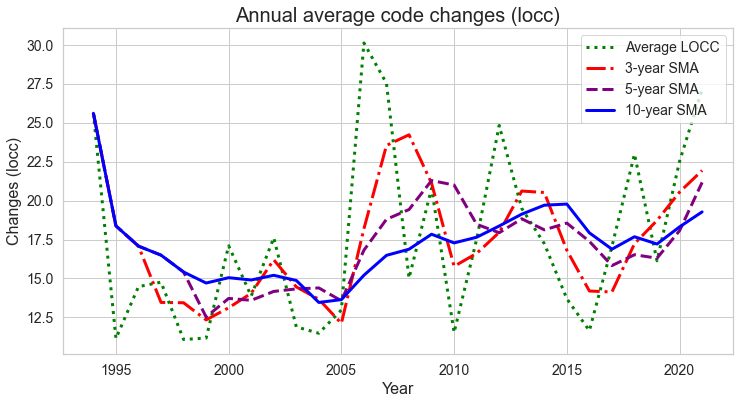

In [9]:
vis.plot_total_locc_moving_avgs()

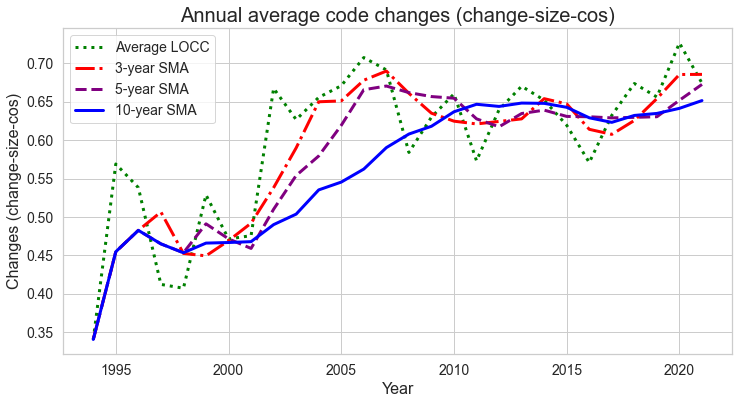

In [10]:
vis.plot_total_locc_moving_avgs(column='change-size-cos')

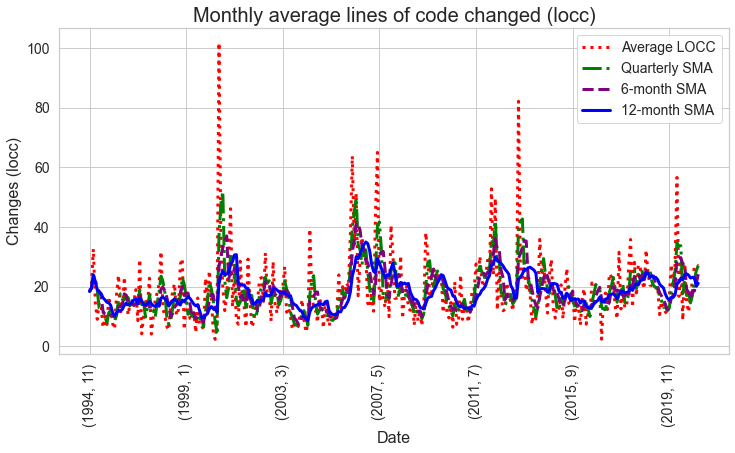

In [11]:
vis.plot_total_locc_moving_avgs_M()

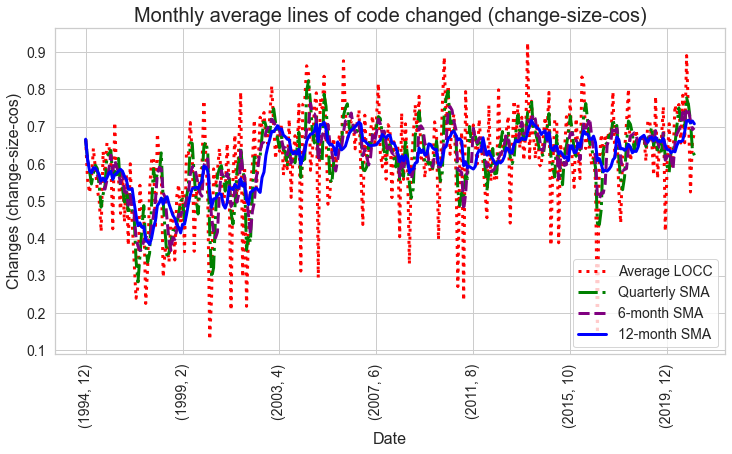

In [12]:
vis.plot_total_locc_moving_avgs_M(column='change-size-cos')

### Custom visualizations with derived data
This reflects changed lines of code as reported in git commit diffs.

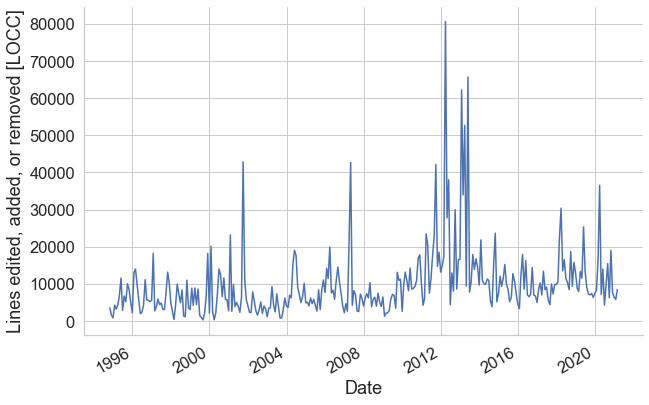

In [13]:
df = vis.plot_project_locc_line()

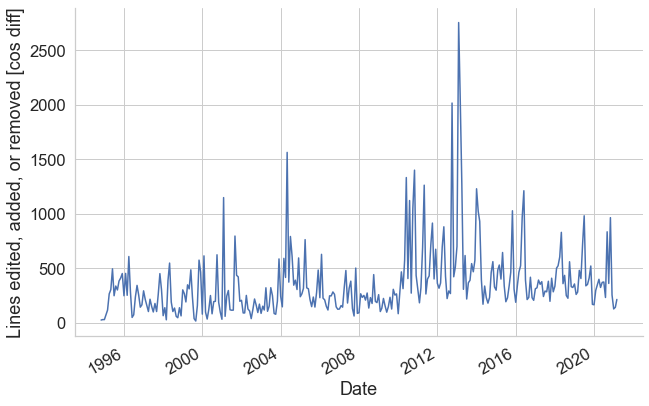

In [14]:
df2 = vis.plot_project_locc_line(locc=False)

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos
datetime,,,,,,,,,
1994-10-31 00:00:00+00:00,209370,1050,1471,30136,3724,3541,75,3283,24
1994-11-30 00:00:00+00:00,175472,968,1537,28289,1689,1613,44,1493,28
1994-12-31 00:00:00+00:00,83748,504,888,14916,975,865,142,613,28
1995-01-31 00:00:00+00:00,261345,131,1927,1927,4742,4270,418,3380,73
1995-02-28 00:00:00+00:00,438900,440,2170,8990,3713,3242,346,2425,115


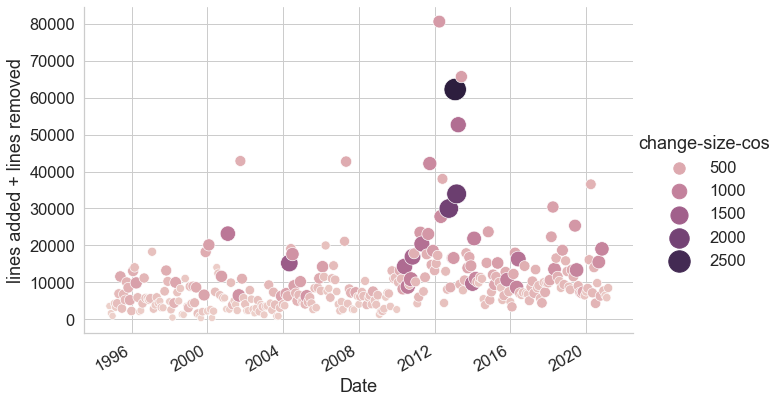

In [15]:
import seaborn as sns
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.relplot(data=df2, x="datetime", y="locc", size="change-size-cos", hue="change-size-cos", sizes=(50, 500),
                    height=6, aspect=1.5, kind="scatter")
    g.ax.set_xlabel('Date')
    g.ax.set_ylabel('lines added + lines removed')
    g.fig.autofmt_xdate()
    g.fig.show()
df.head()

### Using a distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```

,year,month,day,doy,locc-basic,locc,locc-,locc+,change-size-cos,change-size-jaccard
datetime,,,,,,,,,,
1994-10-31 00:00:00+00:00,209370,1050,1471,30136,3724,3541,75,3283,24,24
1994-11-30 00:00:00+00:00,175472,968,1537,28289,1689,1613,44,1493,28,28
1994-12-31 00:00:00+00:00,83748,504,888,14916,975,865,142,613,28,28
1995-01-31 00:00:00+00:00,261345,131,1927,1927,4742,4270,418,3380,73,73
1995-02-28 00:00:00+00:00,438900,440,2170,8990,3713,3242,346,2425,115,115


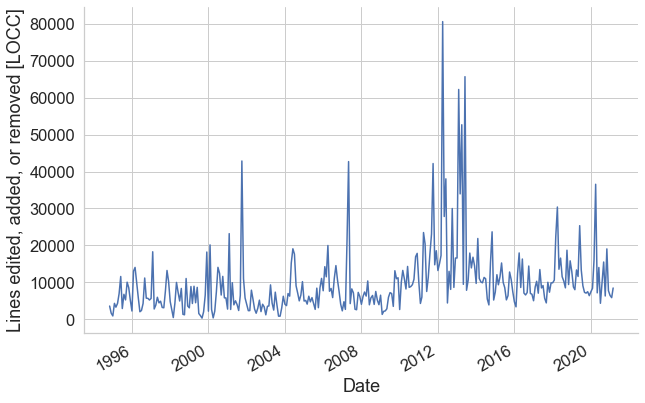

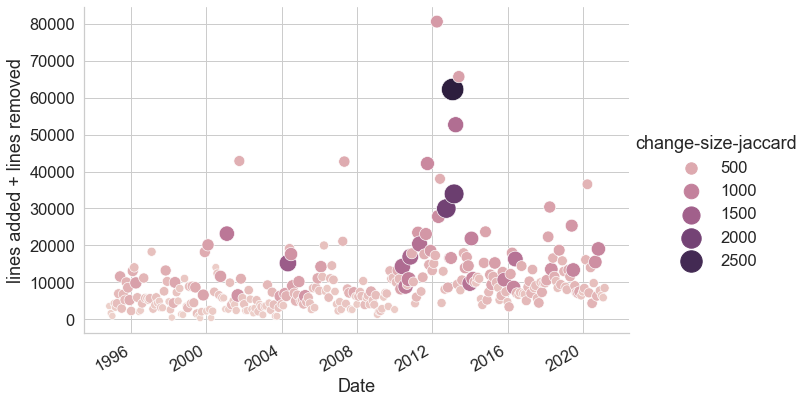

In [16]:
diff_alg = 'jaccard'
vis.set_diff_alg(diff_alg)
df = vis.plot_project_locc_line(diff_alg=diff_alg, log=False)
import seaborn as sns
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.relplot(data=df, x="datetime", y="locc", size="change-size-%s" % diff_alg, hue="change-size-%s" % diff_alg, sizes=(50, 500),
                    height=6, aspect=1.5, kind="scatter")
    g.ax.set_xlabel('Date')
    g.ax.set_ylabel('lines added + lines removed')
    g.fig.autofmt_xdate()
    g.fig.show()
df.head()

## Change size over time

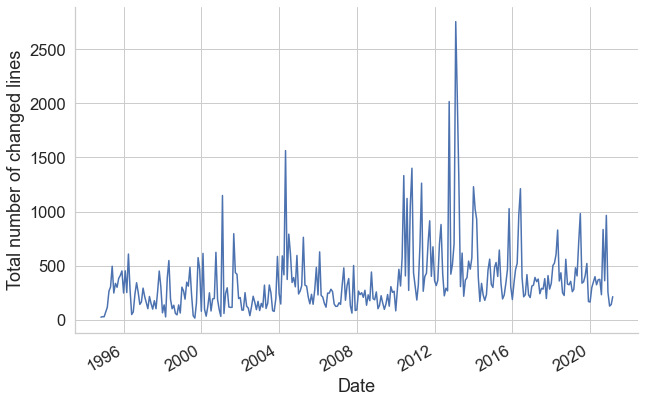

In [17]:
df = vis.plot_proj_change_size(time_range=None)

Similarly, we can 'zoom' into a specific year

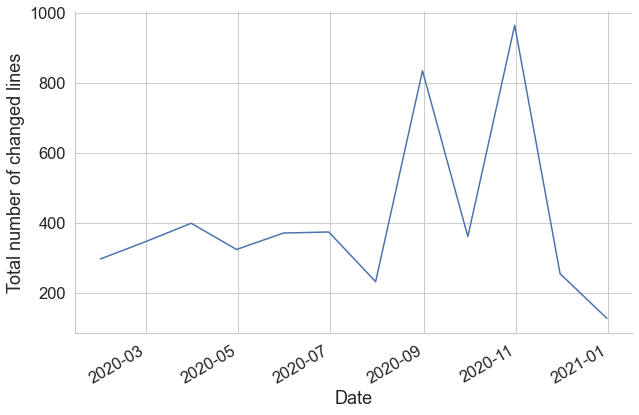

In [18]:
df = vis.plot_proj_change_size(time_range='year')

Or a specific year range

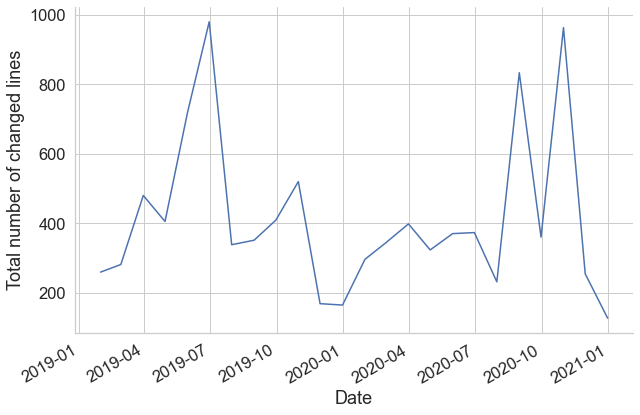

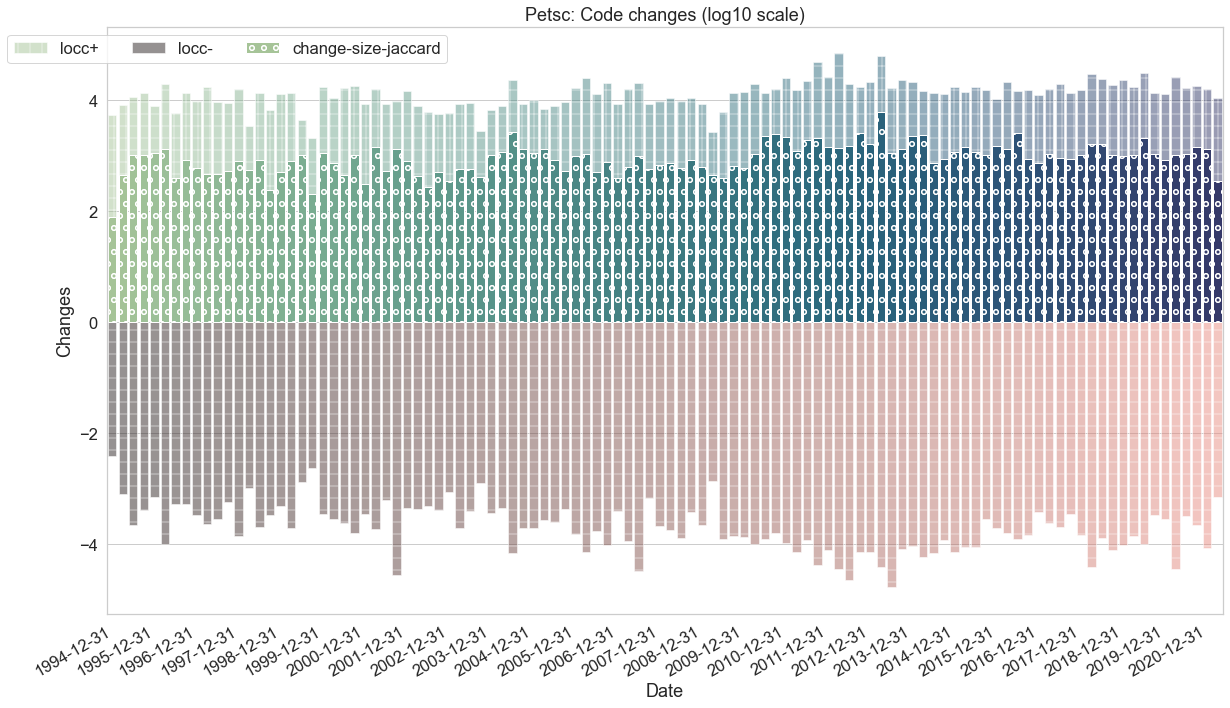

In [19]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_size(time_range='year-year')
df = vis.plot_overall_project_locc(time_range='year-year',log=True)

we can zoom into a month

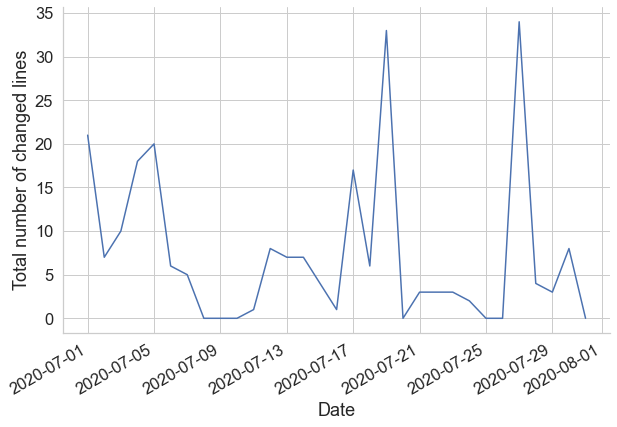

In [20]:
_ = vis.plot_proj_change_size(time_range='month')

Or a month range

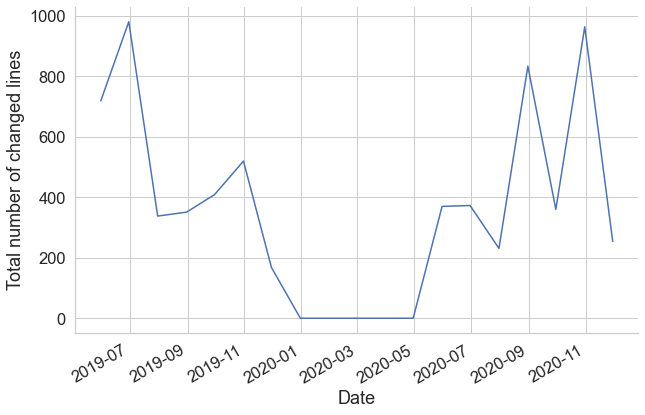

In [21]:
vis.select_month_range(5,11)
df = vis.plot_proj_change_size(time_range='month-month')

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions.

INFO: Creating developer matrix, this can take a few minutes...


unique_author,Barry Smith,Matthew G. Knepley,Hong Zhang,Satish Balay,Stefano Zampini,Jed Brown,Lisandro Dalcin,Lois Curfman McInnes,Shri Abhyankar,Karl Rupp
filepath,,,,,,,,,,
src/dm/dt/interface/dtfe.c,214,13168,0,9,0,1604,4,0,0,2
src/dm/impls/co...les/tests/ex1.c,0,41465,0,0,0,6,0,0,0,0
src/dm/impls/co...mplex/ctetgen.c,226,17202,0,17039,0,3303,0,0,0,0
src/dm/impls/pl...ex/plexrefine.c,21,19181,0,0,5416,28,35,0,0,0
src/dm/impls/plex/plex.c,251,18008,0,5,573,497,183,0,4,374


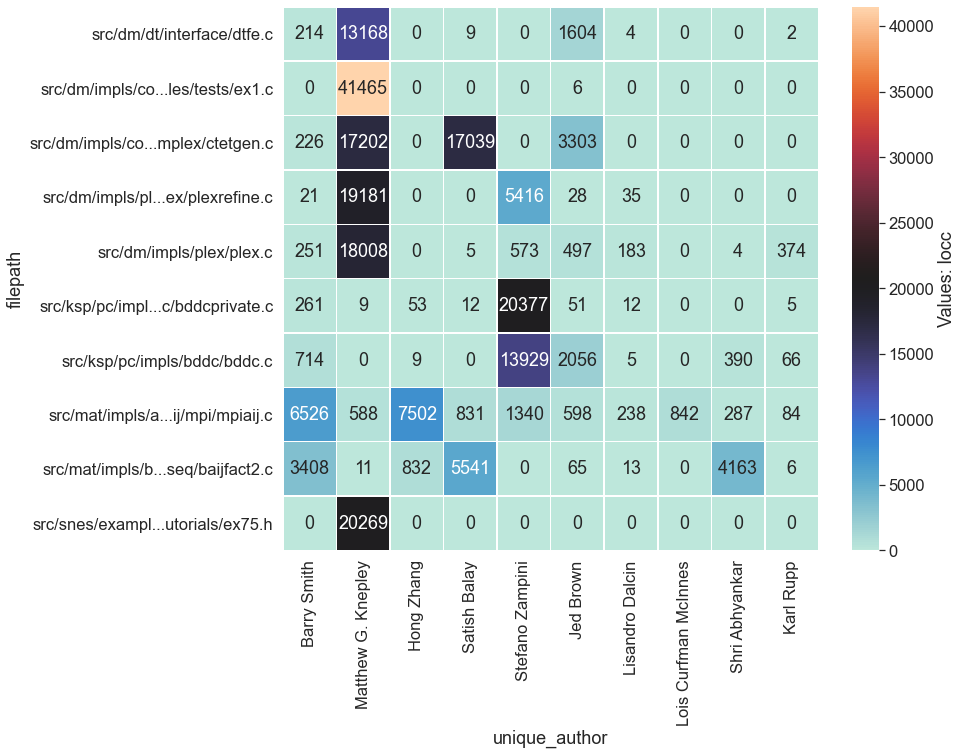

In [31]:
N = 10
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, value_column='locc')
top_N.head()

INFO: Creating developer matrix, this can take a few minutes...


unique_author,Barry Smith,Matthew G. Knepley,Satish Balay,Hong Zhang,Jed Brown,Lisandro Dalcin,Stefano Zampini,Lois Curfman McInnes,Karl Rupp,Shri Abhyankar
filepath,,,,,,,,,,
config/builder.py,34,348,3,0,8,1,1,0,3,0
src/dm/impls/plex/plex.c,39,277,4,0,31,6,28,0,8,0
src/ksp/pc/impl...c/bddcprivate.c,28,3,4,3,5,2,399,0,1,0
src/mat/impls/a...ij/mpi/mpiaij.c,433,35,72,200,48,11,33,60,11,7
src/mat/impls/aij/seq/aij.c,411,20,69,126,37,15,28,33,8,19


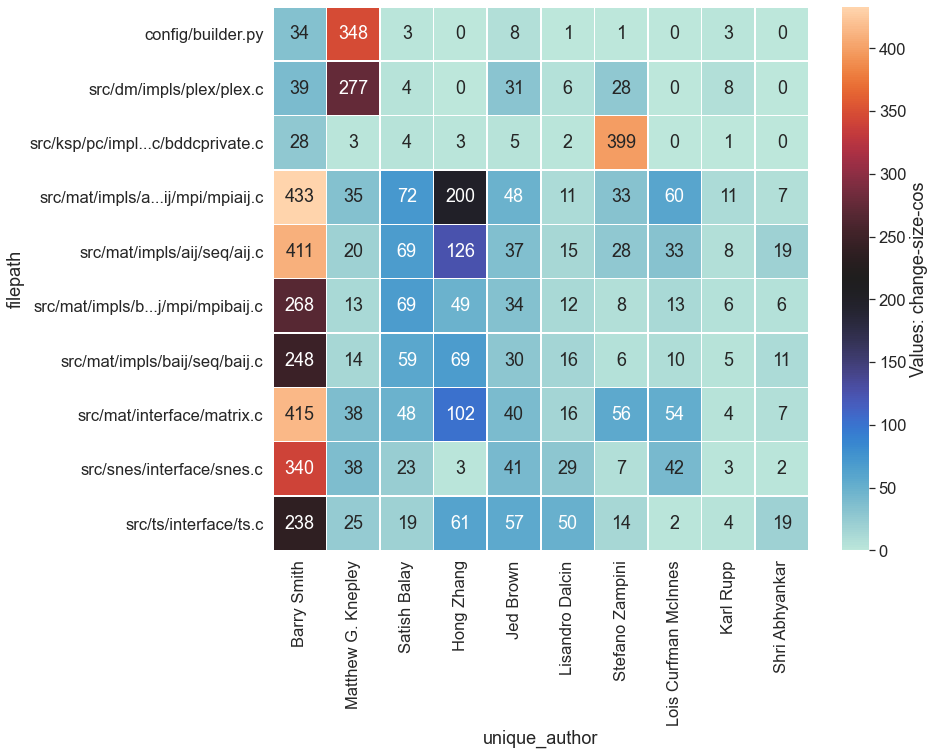

In [37]:
import seaborn as sns
top_N_cos = vis.plot_top_N_heatmap(N, value_column='change-size-cos')
top_N_cos.head()

In [38]:
from patterns.patterns import Patterns
df = vis.commit_data

In [39]:
file_dev_locc = vis.make_file_developer_df(value_column='locc')
file_dev_diff = vis.make_file_developer_df(value_column='change-size-cos')

INFO: Creating developer matrix, this can take a few minutes...
INFO: Creating developer matrix, this can take a few minutes...


In [40]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print(diff_df.shape)
diff_df.head()

(8223, 235)


unique_author,Adam Denchfield,Adam Oberman,Administrator,Adrian Croucher,Adrian Maldonado,Adrián Németh,Albert Cowie,Alejandro Lamas Daviña,Alejandro Otero,Alex Fikl,...,sarens,sdaitch,sepideh,tbridel,tmunson,victorle,xavier lacoste,xht,xuemin,zianekhodja
filepath,,,,,,,,,,,,,,,,,,,,,
.dir-locals.el,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.gitlab-alcf-ci.yaml,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.gitlab-ci.yml,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.readthedocs.yml,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.travis.yml,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO: Creating developer matrix, this can take a few minutes...


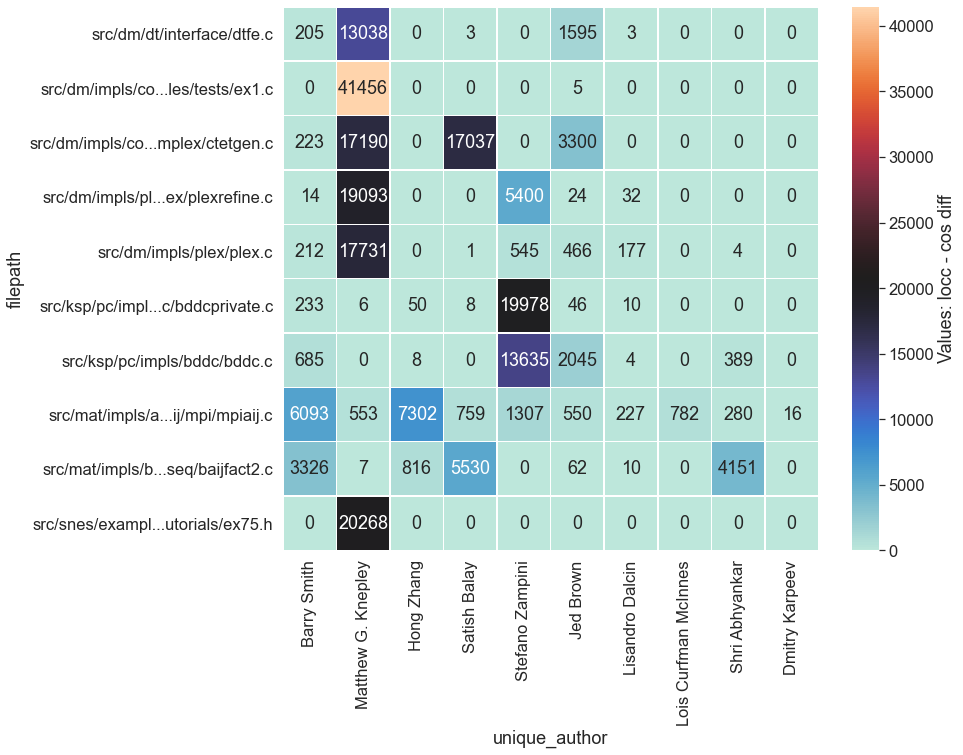

In [27]:
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, value_column='locc - cos diff', my_df=df)

## Did anything unusual happen in 2020?


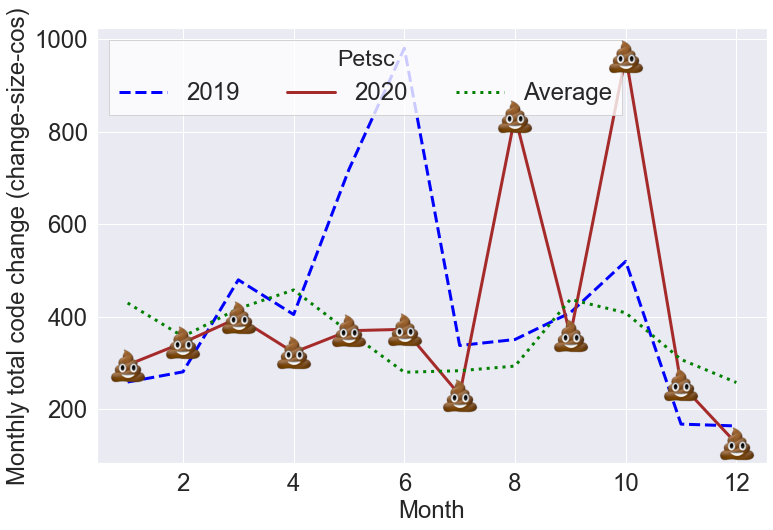

In [42]:
vis.get_data()
vis.how_was_2020('change-size-cos')

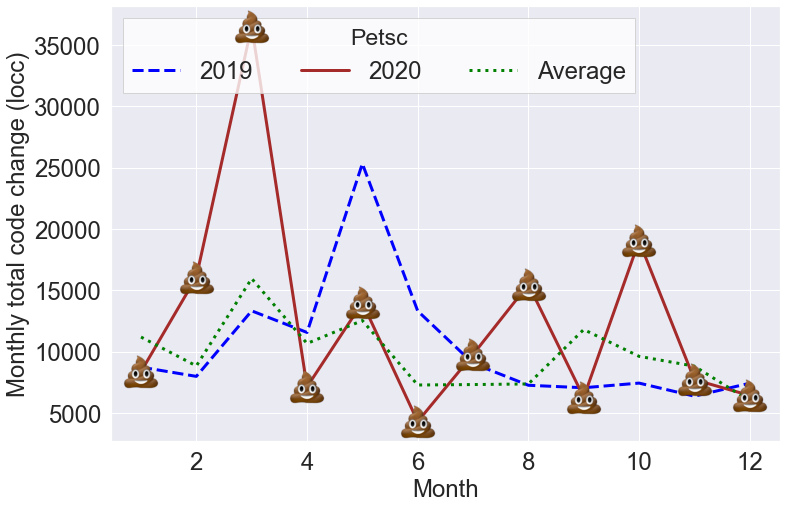

In [43]:
vis.how_was_2020('locc')